In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import optuna


In [2]:
df = pd.read_csv('AAPL.csv', parse_dates=['date'], index_col='date')
data = df[['close']]


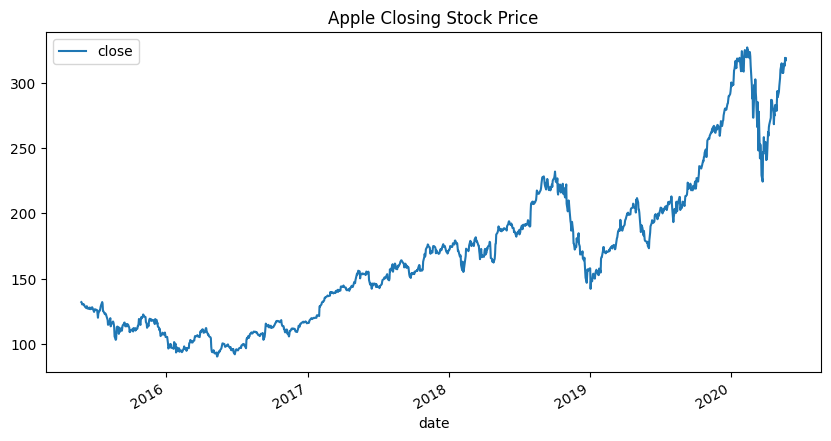

In [3]:
data.plot(title="Apple Closing Stock Price", figsize=(10, 5))
plt.show()


In [4]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    return result[1] <= 0.05

is_stationary = adf_test(data['close'])
if not is_stationary:
    print("Data is not stationary. Differencing will be applied.")
    data['close_diff'] = data['close'].diff().dropna()


ADF Statistic: -0.1001296646773459
p-value: 0.9494256168598443
Critical Values:
   1%: -3.435638861796935
   5%: -2.863875547501718
   10%: -2.5680134763122906
Data is not stationary. Differencing will be applied.


C:\Users\aditya\AppData\Local\Temp\ipykernel_16248\1713702779.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_diff'] = data['close'].diff().dropna()


In [5]:
data['close_diff'] = data['close'].diff()
data.dropna(subset=['close_diff'], inplace=True)


C:\Users\aditya\AppData\Local\Temp\ipykernel_16248\2577116595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_diff'] = data['close'].diff()
C:\Users\aditya\AppData\Local\Temp\ipykernel_16248\2577116595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['close_diff'], inplace=True)


In [6]:
is_stationary_after_diff = adf_test(data['close_diff'])
if is_stationary_after_diff:
    print("Data is stationary after differencing.")
else:
    print("Data is still not stationary. Further transformations may be required.")


ADF Statistic: -6.239529846021873
p-value: 4.734448928661155e-08
Critical Values:
   1%: -3.435638861796935
   5%: -2.863875547501718
   10%: -2.5680134763122906
Data is stationary after differencing.


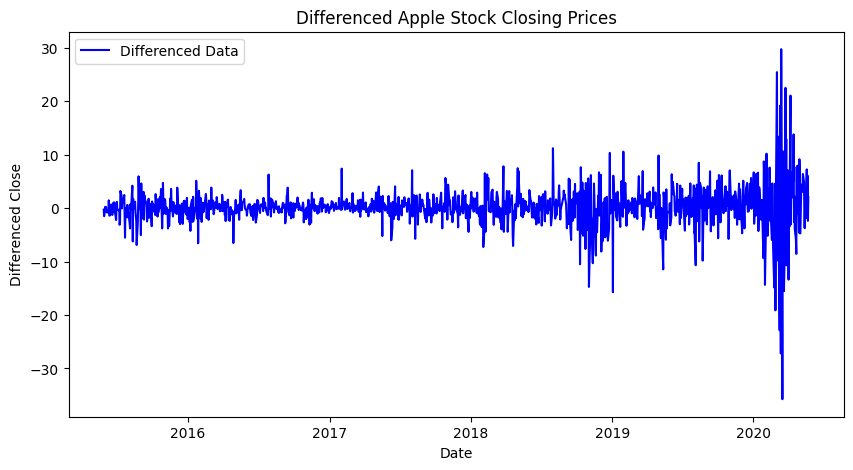

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(data['close_diff'], label="Differenced Data", color='blue')
plt.title("Differenced Apple Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Close")
plt.legend()
plt.show()


In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box Test on the differenced data
# Specify lags to test for autocorrelation (e.g., up to lag 20)
ljung_box_result = acorr_ljungbox(data['close_diff'], lags=[10, 20, 30], return_df=True)

# Display the results
print("Ljung-Box Test Results:")
print(ljung_box_result)


Ljung-Box Test Results:
       lb_stat     lb_pvalue
10  257.563327  1.391979e-49
20  365.803758  2.447428e-65
30  417.305999  8.804302e-70


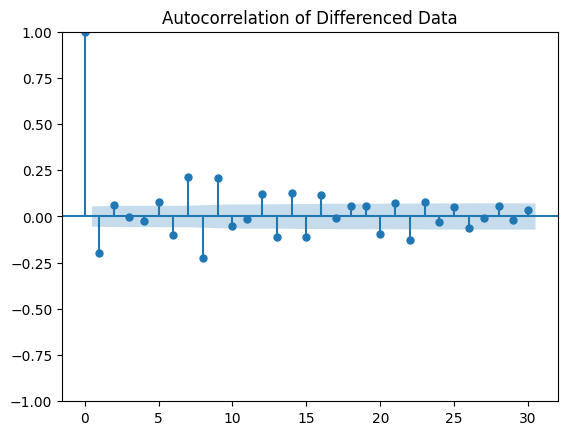

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF of the differenced data
plot_acf(data['close_diff'], lags=30, title="Autocorrelation of Differenced Data")
plt.show()


In [12]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'close' column (original data for LSTM processing)
data['close_normalized'] = scaler.fit_transform(data[['close']])

# Display the first few rows of normalized data
print(data[['close', 'close_normalized']].head())

                             close  close_normalized
date                                                
2015-05-28 00:00:00+00:00  131.780          0.174956
2015-05-29 00:00:00+00:00  130.280          0.168623
2015-06-01 00:00:00+00:00  130.535          0.169699
2015-06-02 00:00:00+00:00  129.960          0.167272
2015-06-03 00:00:00+00:00  130.120          0.167947


C:\Users\aditya\AppData\Local\Temp\ipykernel_16248\3633572283.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_normalized'] = scaler.fit_transform(data[['close']])


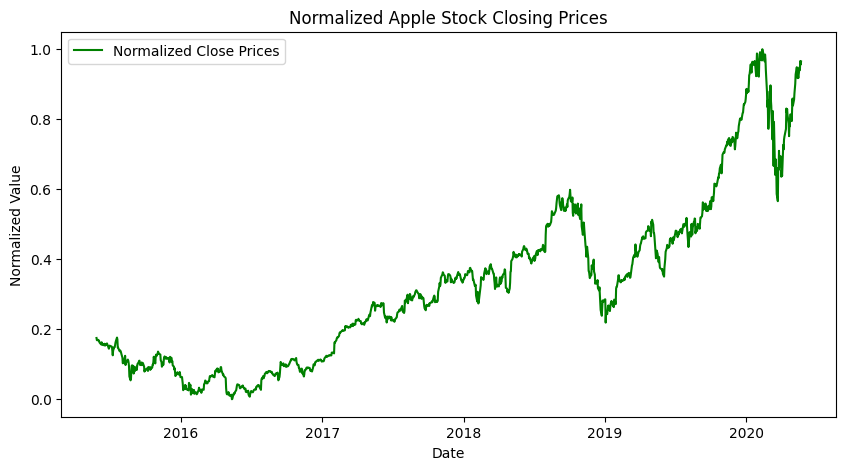

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(data['close_normalized'], label="Normalized Close Prices", color='green')
plt.title("Normalized Apple Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


In [14]:
# Function to create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define the time step (e.g., 60 past observations)
time_steps = 60

# Create sequences using the normalized 'close' column
normalized_close = data['close_normalized'].values
X, y = create_sequences(normalized_close, time_steps)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (1197, 60)
Shape of y: (1197,)


In [15]:
# Define the train-test split ratio
train_size = int(len(X) * 0.8)

# Split data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set: X_train: (957, 60), y_train: (957,)
Testing set: X_test: (240, 60), y_test: (240,)


In [17]:
print(f"Shape of X_train: {X_train.shape}")


Shape of X_train: (957, 60)


In [18]:
# Reshaping the data to be 3D for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify the new shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (957, 60, 1)
Shape of X_test: (240, 60, 1)


In [20]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Build the stacked LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predict the next value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=1)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - loss: 0.0261 - val_loss: 0.0133
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0011 - val_loss: 0.0077
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/ste

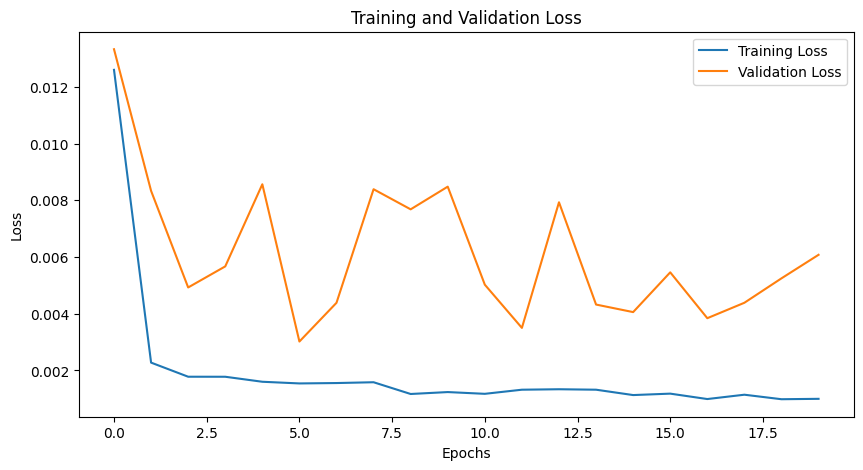

In [22]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# Evaluate on test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0036
Test Loss: 0.006077624391764402


In [24]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Reshape predictions and actual values for visualization (if needed)
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Invert scaling to get actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step


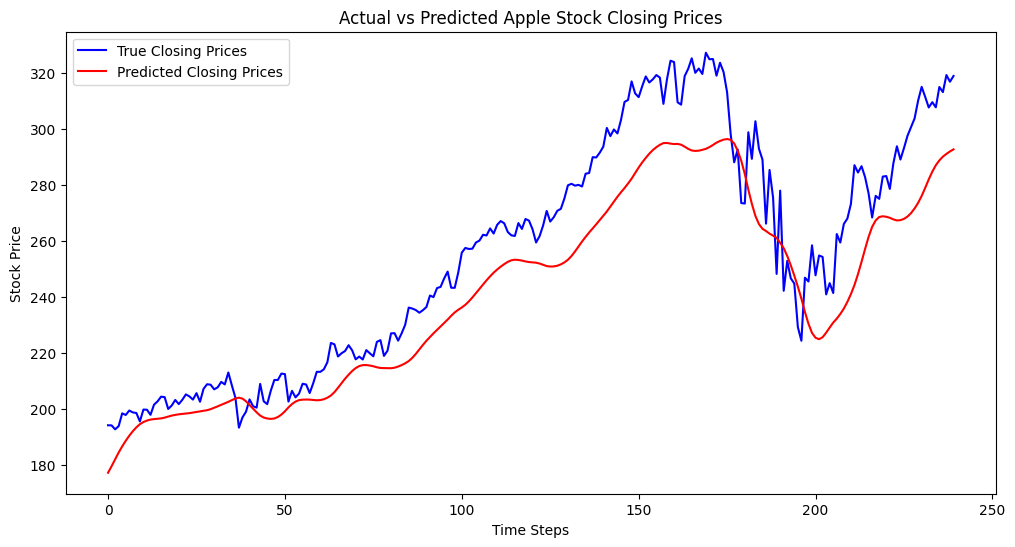

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="True Closing Prices", color='blue')
plt.plot(y_pred_actual, label="Predicted Closing Prices", color='red')
plt.title("Actual vs Predicted Apple Stock Closing Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 18.465392720519436
Mean Absolute Error (MAE): 15.83178345489502


In [27]:
import optuna
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define hyperparameter search space
    n_units = trial.suggest_int("n_units", 30, 100)  # Number of LSTM units
    n_layers = trial.suggest_int("n_layers", 2, 3)  # Number of LSTM layers
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])  # Batch size

    # Build the model
    model = Sequential()
    for i in range(n_layers):
        return_sequences = True if i < n_layers - 1 else False
        model.add(LSTM(units=n_units, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=0)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse  # Minimize RMSE


In [28]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Run for 30 trials (can be increased)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-11-30 01:20:35,939] A new study created in memory with name: no-name-fee56b5c-05af-4b1b-a117-fd6aec65ddce
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step


[I 2024-11-30 01:21:32,806] Trial 0 finished with value: 0.06484834482841911 and parameters: {'n_units': 92, 'n_layers': 3, 'dropout_rate': 0.22563488676009893, 'learning_rate': 0.00037428706756962237, 'batch_size': 64}. Best is trial 0 with value: 0.06484834482841911.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step


[I 2024-11-30 01:22:13,801] Trial 1 finished with value: 0.07480557642435384 and parameters: {'n_units': 57, 'n_layers': 3, 'dropout_rate': 0.4008253264379237, 'learning_rate': 0.00030088087565407226, 'batch_size': 64}. Best is trial 0 with value: 0.06484834482841911.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


[I 2024-11-30 01:23:14,286] Trial 2 finished with value: 0.035852954601153675 and parameters: {'n_units': 77, 'n_layers': 2, 'dropout_rate': 0.2972006672470614, 'learning_rate': 0.004839754556496441, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step


[I 2024-11-30 01:24:04,671] Trial 3 finished with value: 0.08101859927175656 and parameters: {'n_units': 42, 'n_layers': 3, 'dropout_rate': 0.3974412331212578, 'learning_rate': 0.00019981295847405566, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step


[I 2024-11-30 01:25:24,375] Trial 4 finished with value: 0.0821434592714353 and parameters: {'n_units': 49, 'n_layers': 3, 'dropout_rate': 0.38763076969354204, 'learning_rate': 0.0014699296008628987, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step


[I 2024-11-30 01:26:19,994] Trial 5 finished with value: 0.0461401678953103 and parameters: {'n_units': 64, 'n_layers': 3, 'dropout_rate': 0.11339282811113978, 'learning_rate': 0.008281629408576487, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


[I 2024-11-30 01:27:05,129] Trial 6 finished with value: 0.050509648116451054 and parameters: {'n_units': 93, 'n_layers': 2, 'dropout_rate': 0.160964393961207, 'learning_rate': 0.0013915258916657937, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


[I 2024-11-30 01:27:55,521] Trial 7 finished with value: 0.04694462028288445 and parameters: {'n_units': 100, 'n_layers': 2, 'dropout_rate': 0.4728412848402379, 'learning_rate': 0.00826074574355101, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


[I 2024-11-30 01:28:21,513] Trial 8 finished with value: 0.09781719582690168 and parameters: {'n_units': 47, 'n_layers': 2, 'dropout_rate': 0.328200521252071, 'learning_rate': 0.00011272776560231133, 'batch_size': 64}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


[I 2024-11-30 01:29:21,124] Trial 9 finished with value: 0.05623157175888783 and parameters: {'n_units': 72, 'n_layers': 2, 'dropout_rate': 0.4402859801813268, 'learning_rate': 0.0005218717991361691, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


[I 2024-11-30 01:30:21,899] Trial 10 finished with value: 0.05020164582330377 and parameters: {'n_units': 78, 'n_layers': 2, 'dropout_rate': 0.26353735167688314, 'learning_rate': 0.003315996883776511, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step


[I 2024-11-30 01:31:47,854] Trial 11 finished with value: 0.07049876559884438 and parameters: {'n_units': 66, 'n_layers': 3, 'dropout_rate': 0.1260648286731378, 'learning_rate': 0.009943827203637276, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


[I 2024-11-30 01:32:30,712] Trial 12 finished with value: 0.05795284136977703 and parameters: {'n_units': 78, 'n_layers': 2, 'dropout_rate': 0.2010229539280156, 'learning_rate': 0.0040341965367130155, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step


[I 2024-11-30 01:33:43,084] Trial 13 finished with value: 0.07554262418693958 and parameters: {'n_units': 30, 'n_layers': 3, 'dropout_rate': 0.1021626126034581, 'learning_rate': 0.0038498370077570333, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


[I 2024-11-30 01:34:20,375] Trial 14 finished with value: 0.04764709147355886 and parameters: {'n_units': 60, 'n_layers': 2, 'dropout_rate': 0.3052679706154252, 'learning_rate': 0.0053419639687298116, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step


[I 2024-11-30 01:35:50,338] Trial 15 finished with value: 0.05327945549269007 and parameters: {'n_units': 82, 'n_layers': 3, 'dropout_rate': 0.17306103782094734, 'learning_rate': 0.002274127939489944, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step


[I 2024-11-30 01:36:45,528] Trial 16 finished with value: 0.06467353320848393 and parameters: {'n_units': 67, 'n_layers': 3, 'dropout_rate': 0.2611681338861065, 'learning_rate': 0.0008453581421661801, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


[I 2024-11-30 01:37:32,050] Trial 17 finished with value: 0.05953726460235688 and parameters: {'n_units': 85, 'n_layers': 2, 'dropout_rate': 0.3473788741840948, 'learning_rate': 0.006284938582664932, 'batch_size': 32}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


[I 2024-11-30 01:38:27,370] Trial 18 finished with value: 0.07328513450133661 and parameters: {'n_units': 57, 'n_layers': 2, 'dropout_rate': 0.4996531989589753, 'learning_rate': 0.0023205420921677132, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step


[I 2024-11-30 01:39:15,940] Trial 19 finished with value: 0.08052878094961188 and parameters: {'n_units': 71, 'n_layers': 3, 'dropout_rate': 0.25062373853719055, 'learning_rate': 0.005777714965688016, 'batch_size': 64}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step


[I 2024-11-30 01:40:43,931] Trial 20 finished with value: 0.03928988801832524 and parameters: {'n_units': 74, 'n_layers': 3, 'dropout_rate': 0.15427074940054525, 'learning_rate': 0.0023227030354596753, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step


[I 2024-11-30 01:42:18,962] Trial 21 finished with value: 0.040187950260195074 and parameters: {'n_units': 73, 'n_layers': 3, 'dropout_rate': 0.1616793983185079, 'learning_rate': 0.0024000591679677395, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step


[I 2024-11-30 01:43:50,988] Trial 22 finished with value: 0.06044331967715716 and parameters: {'n_units': 75, 'n_layers': 3, 'dropout_rate': 0.15740520843574637, 'learning_rate': 0.0019309440386625373, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step


[I 2024-11-30 01:45:26,391] Trial 23 finished with value: 0.06503184296814964 and parameters: {'n_units': 85, 'n_layers': 3, 'dropout_rate': 0.19660360018787776, 'learning_rate': 0.001095331791674802, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step


[I 2024-11-30 01:47:03,655] Trial 24 finished with value: 0.07002861470481414 and parameters: {'n_units': 91, 'n_layers': 3, 'dropout_rate': 0.22586820979353683, 'learning_rate': 0.0032003639562206898, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step


[I 2024-11-30 01:48:33,618] Trial 25 finished with value: 0.06844940394895124 and parameters: {'n_units': 81, 'n_layers': 3, 'dropout_rate': 0.14859828039374132, 'learning_rate': 0.0007704465321034742, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


[I 2024-11-30 01:49:31,532] Trial 26 finished with value: 0.040128422636050855 and parameters: {'n_units': 71, 'n_layers': 2, 'dropout_rate': 0.28707025898778704, 'learning_rate': 0.002700306289121676, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step


[I 2024-11-30 01:50:28,806] Trial 27 finished with value: 0.04747322120341373 and parameters: {'n_units': 68, 'n_layers': 2, 'dropout_rate': 0.28847055180537434, 'learning_rate': 0.0015375959092318128, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step


[I 2024-11-30 01:51:26,812] Trial 28 finished with value: 0.048845096440370765 and parameters: {'n_units': 63, 'n_layers': 2, 'dropout_rate': 0.345561412309231, 'learning_rate': 0.004606765043517249, 'batch_size': 16}. Best is trial 2 with value: 0.035852954601153675.
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


[I 2024-11-30 01:52:04,609] Trial 29 finished with value: 0.06534430992692539 and parameters: {'n_units': 89, 'n_layers': 2, 'dropout_rate': 0.29768912847270684, 'learning_rate': 0.0028945405154389777, 'batch_size': 64}. Best is trial 2 with value: 0.035852954601153675.


Best hyperparameters: {'n_units': 77, 'n_layers': 2, 'dropout_rate': 0.2972006672470614, 'learning_rate': 0.004839754556496441, 'batch_size': 16}


In [31]:
best_params = study.best_params

# Build the final model
model = Sequential()
for i in range(best_params["n_layers"]):
    return_sequences = True if i < best_params["n_layers"] - 1 else False
    model.add(LSTM(units=best_params["n_units"], return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(best_params["dropout_rate"]))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, 
                    batch_size=best_params["batch_size"], 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    verbose=1)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - loss: 0.0087 - val_loss: 0.0019
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 9.9392e-04 - val_loss: 0.0050
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0010 - val_loss: 0.0059
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 9.1347e-04 - val_loss: 0.0025
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 9.4537e-04 - val_loss: 0.0013
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 7.6388e-04 - val_loss: 0.0037
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 6.5256e-04 - val_loss: 0.0032
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 7.6265e-04 - val_loss: 0.0042
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 8.6171e-04 - val_loss: 0.0052
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━

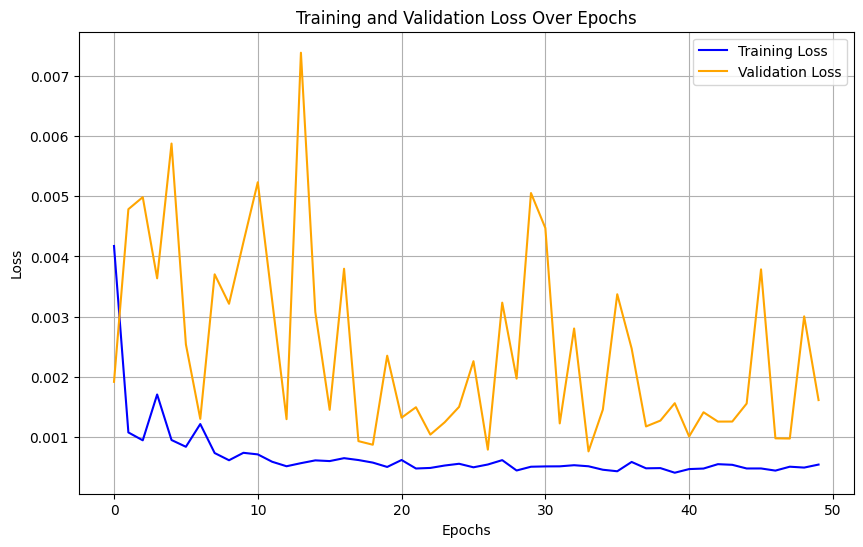

In [32]:
# Extract loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [33]:
# Predict on the test set
y_pred = model.predict(X_test)

# Invert scaling for actual predictions
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast next values
last_sequence = X_test[-1]  # Last sequence in the test set
n_future_steps = 10  # Number of steps to forecast

future_predictions = []
for _ in range(n_future_steps):
    next_pred = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
    future_predictions.append(next_pred[0, 0])
    next_pred_scaled = scaler.transform(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred_scaled).reshape(-1, 1)

# Invert scaling for future predictions
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


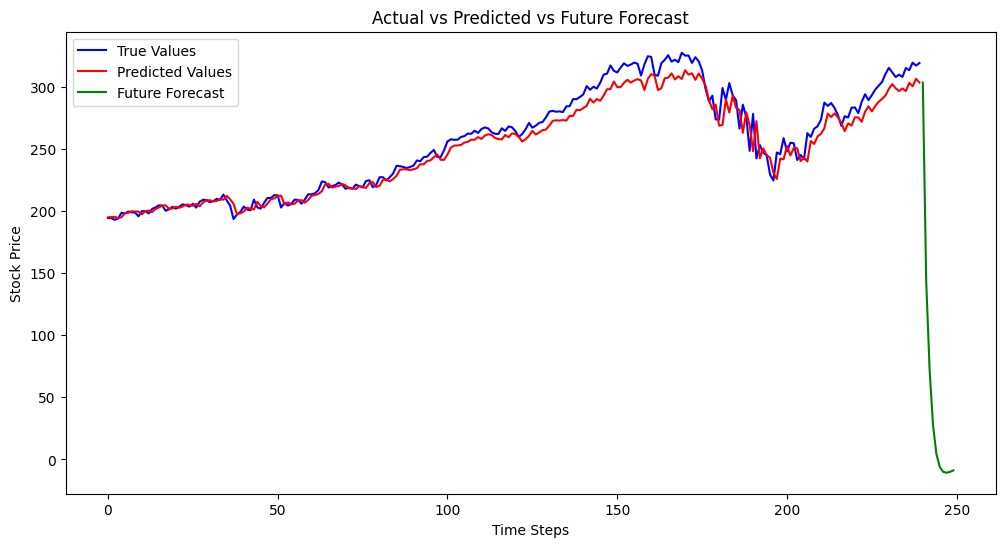

In [34]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="True Values", color='blue')
plt.plot(y_pred_actual, label="Predicted Values", color='red')

# Append future predictions to the plot
future_steps = np.arange(len(y_test_actual), len(y_test_actual) + len(future_predictions_actual))
plt.plot(future_steps, future_predictions_actual, label="Future Forecast", color='green')

plt.title("Actual vs Predicted vs Future Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], 
                    verbose=1)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 4.0912e-04 - val_loss: 0.0012
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 4.0356e-04 - val_loss: 0.0021
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 4.3464e-04 - val_loss: 0.0016
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 3.6696e-04 - val_loss: 9.9612e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 3.9304e-04 - val_loss: 0.0028
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 4.6507e-04 - val_loss: 9.8195e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 3.3306e-04 - val_loss: 0.0012
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 3.4110e-04 - val_loss: 0.0012
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 3.4668e-04 - val_loss: 0.0015
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 3.9366e-04 - val_loss: 0.0011
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 3.0801e-04 - val_loss: 0.0011


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


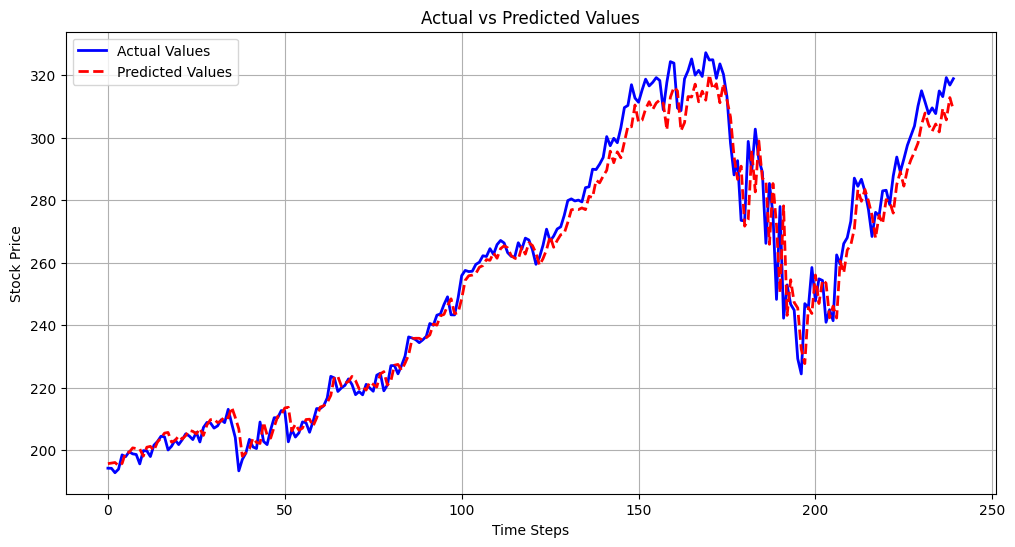

In [36]:
# Predict on the test set
y_pred = model.predict(X_test)

# Invert scaling for the predicted values and actual test values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values", color='blue', linewidth=2)
plt.plot(y_pred_actual, label="Predicted Values", color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

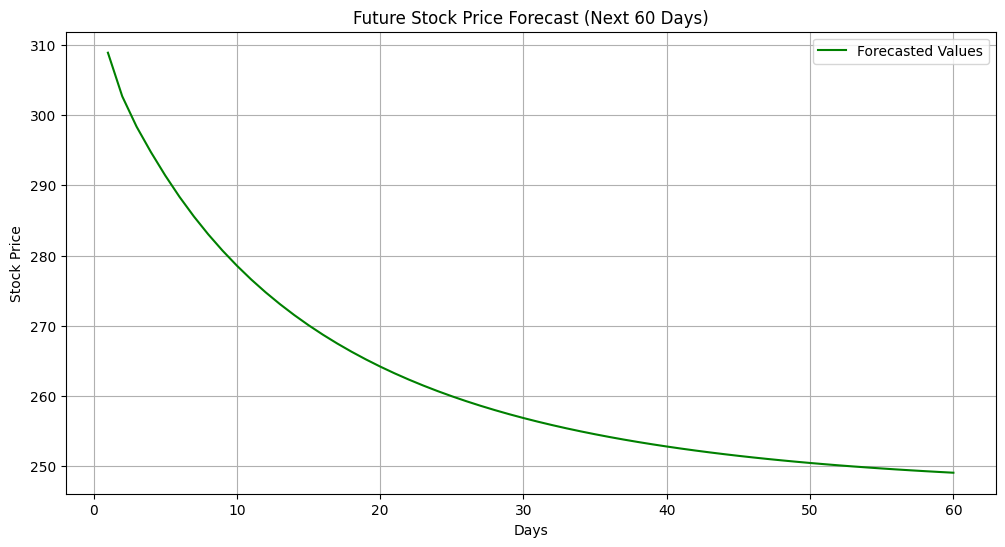

In [38]:
# Number of days to forecast
forecast_days = 60

# Initialize an array with the last sequence from the test set
last_sequence = X_test[-1]  # Shape: (timesteps, features)
future_predictions = []

for _ in range(forecast_days):
    # Reshape the last sequence for prediction
    input_sequence = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])
    
    # Predict the next value
    next_value = model.predict(input_sequence)
    
    # Append the prediction to the results
    future_predictions.append(next_value[0, 0])  # Extract scalar prediction
    
    # Update the last sequence by appending the predicted value
    next_value_scaled = next_value[0]  # Keep it scaled
    last_sequence = np.vstack([last_sequence[1:], next_value_scaled])  # Slide window

# Invert scaling for the predictions
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(range(1, forecast_days + 1), future_predictions_actual, label="Forecasted Values", color='green')
plt.title("Future Stock Price Forecast (Next 60 Days)")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate on training set
y_train_pred = model.predict(X_train)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_actual = scaler.inverse_transform(y_train_pred)

# Evaluate on test set
y_test_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

# Function to calculate and print evaluation metrics
def evaluate_metrics(actual, predicted, dataset_name):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    print(f"Evaluation Metrics for {dataset_name} Data:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    print("-" * 40)

# Print metrics for training and test sets
evaluate_metrics(y_train_actual, y_train_pred_actual, "Training")
evaluate_metrics(y_test_actual, y_test_pred_actual, "Test")


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Evaluation Metrics for Training Data:
Mean Absolute Error (MAE): 1.99
Mean Squared Error (MSE): 7.99
Root Mean Squared Error (RMSE): 2.83
R-squared (R²): 0.99
----------------------------------------
Evaluation Metrics for Test Data:
Mean Absolute Error (MAE): 5.12
Mean Squared Error (MSE): 55.09
Root Mean Squared Error (RMSE): 7.42
R-squared (R²): 0.97
----------------------------------------
